Jigsaw Agile Community Rules Classification
## Exploratory Data Analysis (EDA)

This notebook performs EDA on the **train.csv** dataset for the Jigsaw competition. We load the data, inspect its structure, check for missing values, examine class balance, explore basic text features, dig deeper with n-grams and word clouds, and ensure code correctness.

## 1. Setup and Data Loading

Import necessary libraries and load the CSV files from the Kaggle input directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import itertools
from wordcloud import WordCloud

# Kaggle input paths
TRAIN_PATH = '../input/jigsaw-agile-community-rules/train.csv'
TEST_PATH  = '../input/jigsaw-agile-community-rules/test.csv'

# Load datasets
df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print(f"Training data shape: {df_train.shape}")
print(f"Test data shape:     {df_test.shape}")

Training data shape: (2029, 9)
Test data shape:     (10, 8)


## 2. Missing Values and Data Types

Check for nulls and review column types.

In [2]:
df_train.info()

# Count missing values
missing = df_train.isnull().sum()
print("\nMissing values per column:")
print(missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              2029 non-null   int64 
 1   body                2029 non-null   object
 2   rule                2029 non-null   object
 3   subreddit           2029 non-null   object
 4   positive_example_1  2029 non-null   object
 5   positive_example_2  2029 non-null   object
 6   negative_example_1  2029 non-null   object
 7   negative_example_2  2029 non-null   object
 8   rule_violation      2029 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 142.8+ KB

Missing values per column:
row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
rule_violation        0
dtype: int64


## 3. Unique Values and Class Distribution

Examine how many unique rules and subreddits, and look at imbalance in the target.

Number of unique rules:      2
Number of unique subreddits: 100


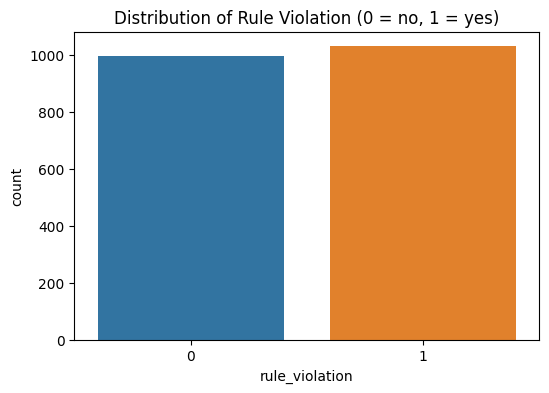

Overall violation rate: 0.508


In [3]:
# Unique counts
n_rules      = df_train['rule'].nunique()
n_subreddits = df_train['subreddit'].nunique()
print(f"Number of unique rules:      {n_rules}")
print(f"Number of unique subreddits: {n_subreddits}")

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='rule_violation', data=df_train)
plt.title('Distribution of Rule Violation (0 = no, 1 = yes)')
plt.show()

# Overall violation rate
rate_overall = df_train['rule_violation'].mean()
print(f"Overall violation rate: {rate_overall:.3f}")

## 4. Violation Rate by Rule and Subreddit

Compute violation rate grouped by rule and by subreddit (top 10).

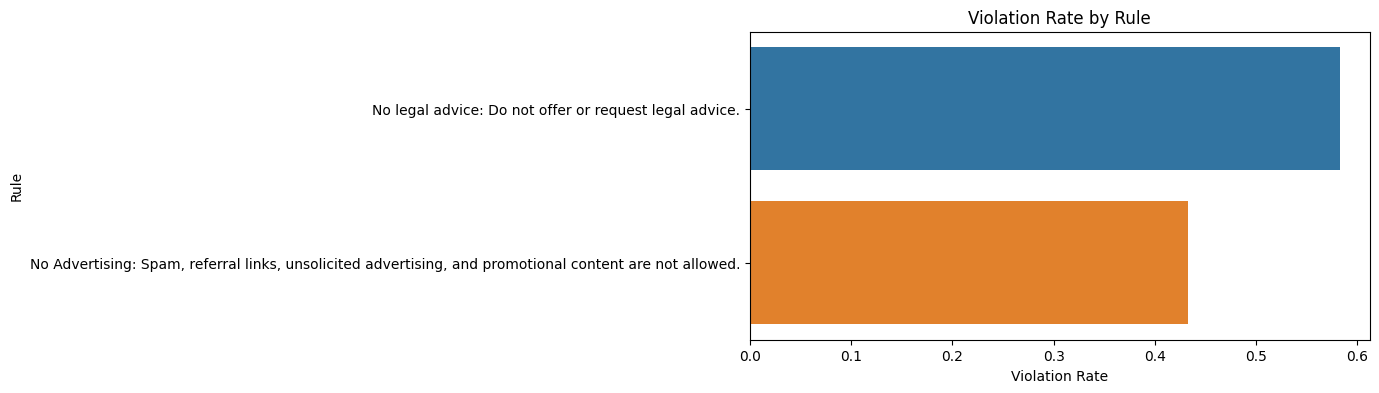

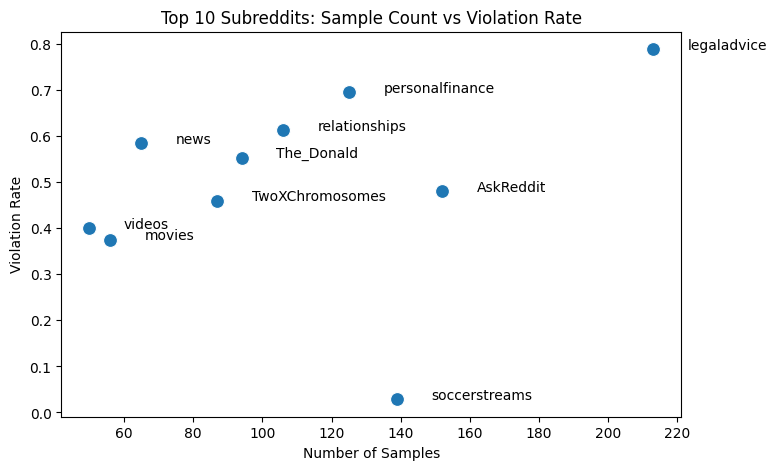

In [4]:
# By rule
rule_stats = df_train.groupby('rule')['rule_violation'] \
    .agg(['mean', 'count']) \
    .rename(columns={'mean':'violation_rate','count':'num_samples'}) \
    .sort_values('num_samples', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x='violation_rate', y=rule_stats.index, data=rule_stats.reset_index())
plt.title('Violation Rate by Rule')
plt.xlabel('Violation Rate')
plt.ylabel('Rule')
plt.show()

# By subreddit (top 10)
sub_stats = df_train.groupby('subreddit')['rule_violation'] \
    .agg(['mean','count']) \
    .rename(columns={'mean':'violation_rate','count':'num_samples'}) \
    .sort_values('num_samples', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.scatterplot(x='num_samples', y='violation_rate', data=sub_stats.reset_index(), s=100)
for _, row in sub_stats.reset_index().iterrows():
    plt.text(row['num_samples']+10, row['violation_rate'], row['subreddit'])
plt.title('Top 10 Subreddits: Sample Count vs Violation Rate')
plt.xlabel('Number of Samples')
plt.ylabel('Violation Rate')
plt.show()

## 5. Comment Length Distribution

Analyze distribution of comment lengths in characters and words.

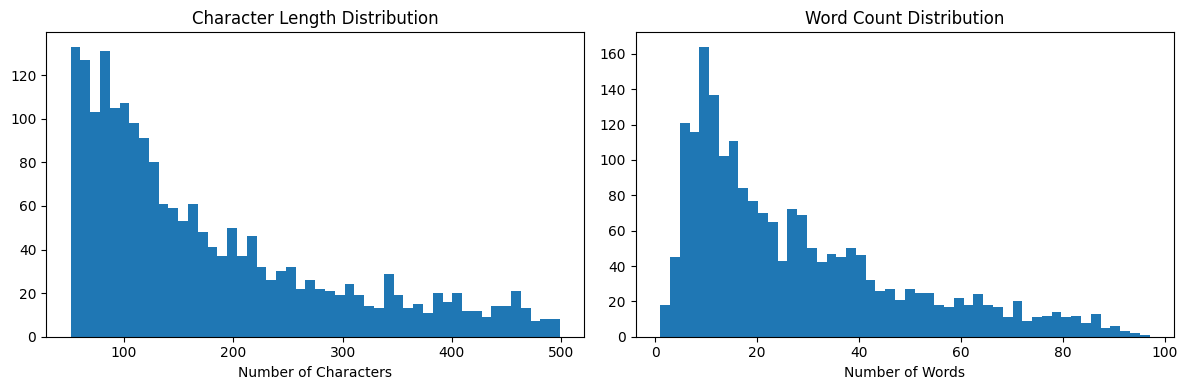

In [5]:
df_train['char_len'] = df_train['body'].str.len()
df_train['word_len'] = df_train['body'].str.split().map(len)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(df_train['char_len'], bins=50)
axes[0].set_title('Character Length Distribution')
axes[0].set_xlabel('Number of Characters')

axes[1].hist(df_train['word_len'], bins=50)
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

## 6. Common N-grams for Violations vs Non-violations

Identify top unigrams and bigrams in violated vs non-violated comments.

In [6]:
import re
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizers
vectorizer_uni = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=5)
vectorizer_bi  = CountVectorizer(ngram_range=(2,2), stop_words='english', min_df=5)

# Fit on all comments
grams_uni = vectorizer_uni.fit_transform(df_train['body'].fillna(""))
grams_bi  = vectorizer_bi.fit_transform(df_train['body'].fillna(""))

# Feature names
feat_uni = np.array(vectorizer_uni.get_feature_names_out())
feat_bi  = np.array(vectorizer_bi.get_feature_names_out())

# Function to get top n-grams for a class
def get_top_ngrams(matrix, labels, feat_names, cls, top_n=20):
    # Select rows for the class
    idx = np.where(labels == cls)[0]
    # Sum term frequencies
    class_sum = np.asarray(matrix[idx].sum(axis=0)).ravel()
    # Get top indices
    top_idx = class_sum.argsort()[::-1][:top_n]
    return feat_names[top_idx]

# Compute top n-grams for each class
labels = df_train['rule_violation'].values
top_uni_non = get_top_ngrams(grams_uni, labels, feat_uni, cls=0)
top_uni_vio = get_top_ngrams(grams_uni, labels, feat_uni, cls=1)
top_bi_non  = get_top_ngrams(grams_bi, labels, feat_bi, cls=0)
top_bi_vio  = get_top_ngrams(grams_bi, labels, feat_bi, cls=1)

print("Top 20 Unigrams (No Violation):", top_uni_non)
print("Top 20 Unigrams (Violation):",   top_uni_vio)
print("Top 20 Bigrams (No Violation):",  top_bi_non)
print("Top 20 Bigrams (Violation):",    top_bi_vio)

Top 20 Unigrams (No Violation): ['com' 'http' 'www' 'stream' 'https' 'hd' 'html' 'watch' 'live' 'mobile'
 'sd' 'english' 'vs' 'just' 'like' 'tv' 'yes' 'free' 'check' 'don']
Top 20 Unigrams (Violation): ['com' 'http' 'www' 'just' 'don' 'https' 'free' 'legal' 'like' 'sex'
 'want' 'law' 'know' 'people' 'police' 'illegal' 'need' 'money' 'll'
 'right']
Top 20 Bigrams (No Violation): ['http www' 'stream http' 'https www' 'youtube com' 'english stream'
 'www youtube' 'hd stream' 'com watch' 'sd stream' 'twitch tv'
 'html mobile' 'live stream' 'mobile yes' 'check instagram'
 'instagram page' 'page dailyetymology' 'https youtu' 'mobile compatible'
 'interesting check' 'oh interesting']
Top 20 Bigrams (Violation): ['http www' 'https www' 'com free' 'karma glitch' 'glitch fast'
 'reddit karma' 'www freekarma' 'fast patched' 'freekarma com'
 'free reddit' 'girls sex' 'free girls' 'girl sex' 'sex worldwide'
 'findsextoday com' 'mysexfind com' 'com girl' 'child support'
 'http mysexfind' 'flexappweb

## 7. Word Clouds. Word Clouds

Generate word clouds for violated and non-violated comments.

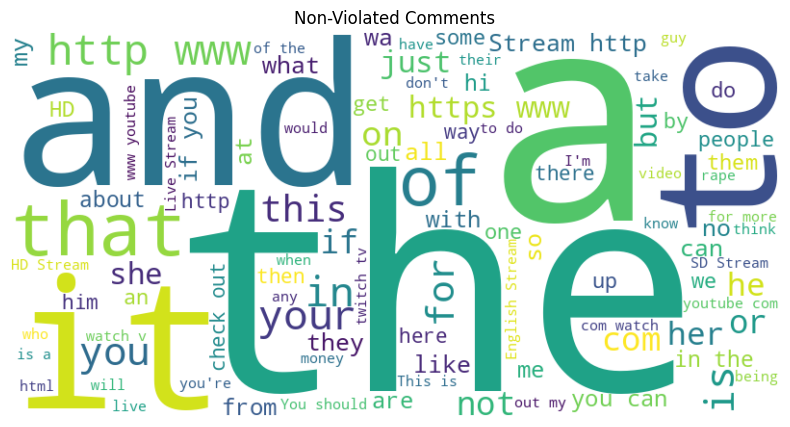

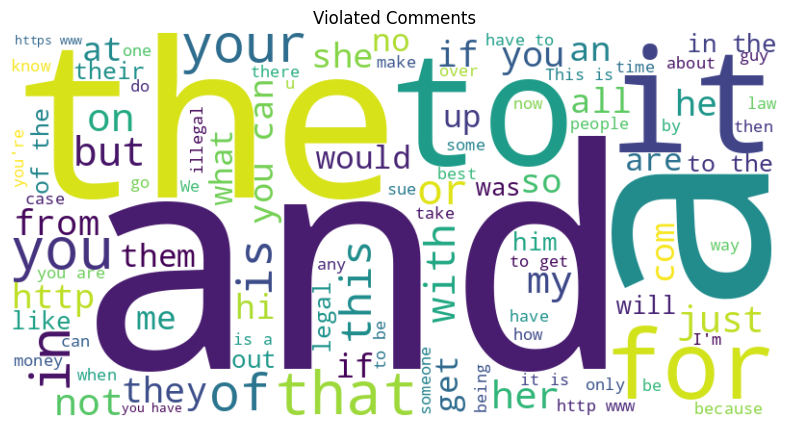

In [7]:
txt_non = " ".join(df_train[df_train['rule_violation']==0]['body'].dropna().tolist())
txt_vio = " ".join(df_train[df_train['rule_violation']==1]['body'].dropna().tolist())

for text, title in [(txt_non, 'Non-Violated Comments'), (txt_vio, 'Violated Comments')]:
    wc = WordCloud(width=800, height=400, background_color='white', stopwords='english', max_words=100)
    wc.generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

## 8. Next Steps

- Text cleaning (remove markdown, URLs, punctuation).  
- Explore POS tags and sentiment.  
- Build baseline model with TF-IDF features including n-grams.  
- Experiment with Transformer-based encoders for rule–comment pairs.